### NLP - Notebook 3

### Modelling Approaches and Testing of NLP Data

In this notebook we will first define an evaluation metric and then begin testing models. 

<b>We are dealing with a multi-label classification problem and have two approaches:</b>

- We can transform the problem into a series of binary classification problems;

- We can use an algorithm that has been adapted for multi-label problems. 

In the first case we will explore four models, and we will try four classifiers for each.  

<b>The four models we will use here are</b>:

- OneVsRest
- Binary Relevance
- Classifier Chains 
- Label Powerset

<b>The classifiers we will use are:</b>

- Logistic Regression
- Multinomial Naive Bayes
- C-Support Vector Classification 
- Random Forest



In terms of adapted algorirthms, we will test Multilabel k Nearest Neighbours (MLkNN).  We will also test two deep learning models that use the embeddings in the next notebook.

### Evaluation Metric

For this multi-label classification problem we have several choices for an evaluation metric.  Some of these are Log-Loss, AUC (Area Under the ROC Curve), Micro-averaging and Macro Averaging, Hamming-Loss, F1 Score, and Exact Match Ratio.

We will use F1 Score with the parameter average='samples' to allow for use with multiple labels like we have.  Since our label distribution is imbalanced, we will use the Balanced Accuracy Score (exact match ratio) where we evaluate the model individually for each category like we do in OneVsRest.  This accuracy score measures the percentage of rows where each label is correctly predicted.  

### Algorithms for transforming the multi-label classification problem

1 - OneVsRest

Decomposes the problem into one independent binary classification problem per category.  This model assumes that the class labels are mutually exclusive.  It trains a classifier on one class at a time, leaving the rest out.  OneVsRest faces difficulties when the number of label classes is large or when the classes are not independent. 

2 - Binary Relevance

Similar to OneVsRest in that a binary classifier is trained independently for each class label.  The model predicts all labels for a sample for which a postive result was obtained from the respective classifier.  Like OneVsRest this ignores possible correlations between class labels.  

3 - Classifier Chains 

Creates a chain of binary classifiers.  The first is trained on the input data and each subsequent classifier is trained on the results of all previous classifiers as well as the input data.  This takes into account label correlations.  Training with this model will take longer with more label classes.  

4 - Label Powerset

Transforms a multi-label problem into a multi-class problem.  Maps each combination of labels into a single lable and trains a single classifier.  The number of label combinations can grow exponentially as the number of classes increases.  It factors in correlations between labels but has a high computational complexity.  

### Algorithm adapted for multi-label classification

1 - ML-KNN

k-Nearest Neighbours adapted for multi-label classification.  It finds the nearest examples to a test class and uses Bayesian inference to assign the labels.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import the datasets
X_train = pd.read_csv('Data\X_train_nlp.csv')
X_test = pd.read_csv('Data\X_test_nlp.csv')
y_train = pd.read_csv('Data\y_train_nlp.csv')
y_test = pd.read_csv('Data\y_test_nlp.csv')

# Make a copy for later use
X_train2 = X_train.copy()
X_test2 = X_test.copy()

In [3]:
X_train = X_train['no_stop_words']
X_test = X_test['no_stop_words']

In [4]:
# For now we will work with Scikit-Learn's Tfidf Vectorizer.  
# Tfidf (Term Fequency - Inverse Document) assigns a score to a word's importance by measuring a word's frequency 
# within one document and uniqueness across all documents

from sklearn.feature_extraction.text import TfidfVectorizer

# Define the list of categories
categories = list(y_train.columns)

In [5]:
# We will use a pipeline for each test, defining the vectorizer above, the learning algorithm, and the classifier 
from sklearn.pipeline import Pipeline

# We will use accuracy_score as outlined above
from sklearn.metrics import balanced_accuracy_score

### OneVsRest

In [6]:
# OneVs Rest with Logistic Regression Classifer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(), n_jobs=1)),
                ])

# Create a dictionary of the accuracies for plotting 
accuracies_ovr_lr = dict()
for category in categories:
        
    # Training logistic regression model on training data
    LogReg_pipeline.fit(X_train, y_train[category])
    
    # Predicting and calculating test accuracy
    prediction = LogReg_pipeline.predict(X_test)
    accuracies_ovr_lr[category] = balanced_accuracy_score(y_test[category], prediction)
    print('Test accuracy for {} labels is {}'.format(category, accuracies_ovr_lr[category]))

Test accuracy for outerwear labels is 0.9454689252538035
Test accuracy for tops labels is 0.9634146341463414
Test accuracy for pants labels is 0.9612384858468366
Test accuracy for dresses labels is 0.9742607999881461
Test accuracy for skirts labels is 0.9842014962034318


In [7]:
# MULTINOMIAL NAIVE BAYES CLASSIFIER
from sklearn.naive_bayes import MultinomialNB

NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
                ])

accuracies_ovr_nb = dict()

for category in categories:
    
    NB_pipeline.fit(X_train, y_train[category])
    
    prediction = NB_pipeline.predict(X_test)
    accuracies_ovr_nb[category] = balanced_accuracy_score(y_test[category], prediction)
    print('Test accuracy for {} labels is {}'.format(category, accuracies_ovr_nb[category]))

Test accuracy for outerwear labels is 0.8564062005694401
Test accuracy for tops labels is 0.8522357723577236
Test accuracy for pants labels is 0.814365330165774
Test accuracy for dresses labels is 0.6425013150388584
Test accuracy for skirts labels is 0.6708499975658295


In [8]:
# SVC CLASSIFIER
from sklearn.svm import LinearSVC

SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
                ])

accuracies_ovr_svc = dict()

for category in categories:
    
    SVC_pipeline.fit(X_train, y_train[category])
    
    prediction = SVC_pipeline.predict(X_test)
    accuracies_ovr_svc[category] = balanced_accuracy_score(y_test[category], prediction)
    print('Test accuracy for {} labels is {}'.format(category, accuracies_ovr_svc[category]))

Test accuracy for outerwear labels is 0.9640369437585509
Test accuracy for tops labels is 0.9742886178861789
Test accuracy for pants labels is 0.9814578243946899
Test accuracy for dresses labels is 0.9885180438148722
Test accuracy for skirts labels is 0.9877472711474089


In [9]:
# RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier

RF_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(RandomForestClassifier(), n_jobs=1)),
                ])
    
accuracies_ovr_rf = dict()

for category in categories:
    
    RF_pipeline.fit(X_train, y_train[category])
    
    prediction = RF_pipeline.predict(X_test)
    accuracies_ovr_rf[category] = balanced_accuracy_score(y_test[category], prediction)
    print('Test accuracy for {} labels is {}'.format(category, accuracies_ovr_rf[category]))

Test accuracy for outerwear labels is 0.9433448234776929
Test accuracy for tops labels is 0.9604674796747967
Test accuracy for pants labels is 0.940981794004049
Test accuracy for dresses labels is 0.9868777643598539
Test accuracy for skirts labels is 0.9880179804056656


<b> OneVsRest Results:</b>

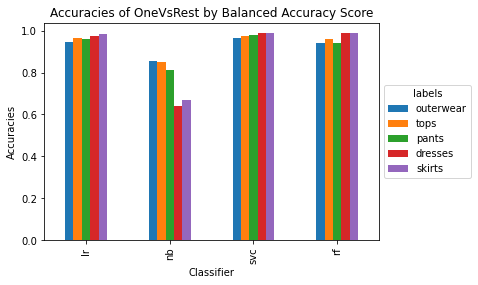

In [10]:
# Store each dictionary within a dictionary to plot
onevrest_results = {'lr': accuracies_ovr_lr, 
                    'nb': accuracies_ovr_nb, 
                    'svc': accuracies_ovr_svc, 
                    'rf': accuracies_ovr_rf}
pd.DataFrame(onevrest_results).T.plot(kind='bar', title='Accuracies of OneVsRest by Balanced Accuracy Score')
plt.ylabel('Accuracies')
plt.xlabel('Classifier')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='labels')
plt.show()

### Binary Relevance

In [11]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import f1_score

# Create a dictionary to store accuracies for plotting
accuracies_br = dict()

In [12]:
# LOGISTIC REGRESSION CLASSIFIER

LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', BinaryRelevance(LogisticRegression(solver='sag'), require_dense=[False, True]))
                ])

# Train
LogReg_pipeline.fit(X_train, y_train)
# Predict
prediction = LogReg_pipeline.predict(X_test)
# Measure accuracy
accuracies_br['lr'] = f1_score(y_test, prediction, average='samples')
print("Accuracy = ", accuracies_br['lr'])

Accuracy =  0.9564137308039747


In [13]:
# MULTINOMIAL NAIVE BAYES CLASSIFIER
from skmultilearn.problem_transform import BinaryRelevance
NB_pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('clf', BinaryRelevance(MultinomialNB(), require_dense=[False, True]))
            ])

NB_pipeline.fit(X_train, y_train)
    
prediction = NB_pipeline.predict(X_test)
accuracies_br['nb'] = f1_score(y_test, prediction, average='samples')
print("Accuracy = ", accuracies_br['nb'])

Accuracy =  0.7653267088226439


In [14]:
# Binary Relevance with Linear SVC CLASSIFIER
from sklearn.svm import LinearSVC
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import f1_score

SVC_pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('clf', BinaryRelevance(LinearSVC(), require_dense=[False, True])),
            ])

SVC_pipeline.fit(X_train, y_train)
    
prediction = SVC_pipeline.predict(X_test)
accuracies_br['svc'] = f1_score(y_test, prediction, average='samples')
print("Accuracy = ", accuracies_br['svc'])

Accuracy =  0.9729298404095151


In [15]:
# RANDOM FOREST CLASSIFIER 
RF_pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('clf', BinaryRelevance(RandomForestClassifier(), require_dense=[False, True])),
            ])

RF_pipeline.fit(X_train, y_train)
    
prediction = RF_pipeline.predict(X_test)
accuracies_br['rf'] = f1_score(y_test, prediction, average='samples')
print("Accuracy = ", accuracies_br['rf'])

Accuracy =  0.9483245149911814


<b> Binary Relevance Results:</b>

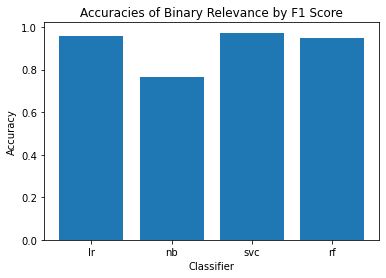

In [16]:
plt.bar(accuracies_br.keys(), accuracies_br.values())
plt.ylabel('Accuracy')
plt.xlabel('Classifier')
plt.title('Accuracies of Binary Relevance by F1 Score')
plt.show()

### Classifier Chains

In [17]:
from skmultilearn.problem_transform import ClassifierChain

# Create a dictionary to store accuracies for plotting
accuracies_cc = dict()

In [18]:
# LOGISTIC REGRESSION CLASSIFIER

LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', ClassifierChain(LogisticRegression(solver='sag')))
                ])
# Train
LogReg_pipeline.fit(X_train, y_train)
# Predict
prediction = LogReg_pipeline.predict(X_test)
# Measure accuracy
accuracies_cc['lr'] = f1_score(y_test, prediction, average='samples')
print("Accuracy = ", accuracies_cc['lr'])

Accuracy =  0.9512496236073471


In [19]:
# MULTINOMIAL NAIVE BAYES CLASSIFIER
NB_pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('clf', ClassifierChain(MultinomialNB()))
            ])

NB_pipeline.fit(X_train, y_train)

prediction = NB_pipeline.predict(X_test)
accuracies_cc['nb'] = f1_score(y_test, prediction, average='samples')
print("Accuracy = ", accuracies_cc['nb'])

Accuracy =  0.7904095152062632


In [20]:
# SVC CLASSIFIER 
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', ClassifierChain(LinearSVC()))
                ])

SVC_pipeline.fit(X_train, y_train)

prediction = SVC_pipeline.predict(X_test)
accuracies_cc['svc'] = f1_score(y_test, prediction, average='samples')
print("Accuracy = ", accuracies_cc['svc'])

Accuracy =  0.9724781692261367


In [21]:
# Classifier Chain with Random Forest Classifier 

RF_pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('clf', ClassifierChain(RandomForestClassifier()))
            ])

RF_pipeline.fit(X_train, y_train)

prediction = RF_pipeline.predict(X_test)
accuracies_cc['rf'] = f1_score(y_test, prediction, average='samples')
print("Accuracy = ", accuracies_cc['rf'])

Accuracy =  0.9486449864498646


<b> Classifier Chains Results:</b>

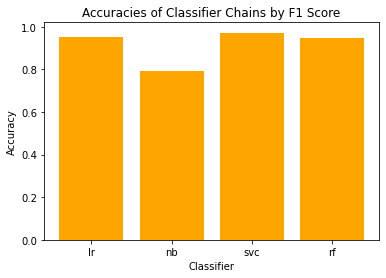

In [22]:
plt.bar(accuracies_cc.keys(), accuracies_cc.values(), color='orange')
plt.ylabel('Accuracy')
plt.xlabel('Classifier')
plt.title('Accuracies of Classifier Chains by F1 Score')
plt.show()

### Label Powerset

In [23]:
from skmultilearn.problem_transform import LabelPowerset

# Create a dictionary to store accuracies for plotting
accuracies_lps = dict()

In [24]:
# LOGISTIC REGRESSION CLASSIFIER
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', LabelPowerset(LogisticRegression(solver='sag')))
                ])

LogReg_pipeline.fit(X_train, y_train)

prediction = LogReg_pipeline.predict(X_test)

accuracies_lps['lr'] = f1_score(y_test, prediction, average='samples')
print("Accuracy = ", accuracies_lps['lr'])

Accuracy =  0.8926227040048179


In [25]:
# Label Powerset with Multinomial Naive Bayes Classifier
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import MultinomialNB

NB_pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('clf', LabelPowerset(MultinomialNB()))
            ])

NB_pipeline.fit(X_train, y_train)

prediction = NB_pipeline.predict(X_test)
accuracies_lps['nb'] = f1_score(y_test, prediction, average='samples')
print("Accuracy = ", accuracies_lps['nb'])

Accuracy =  0.7283047274917194


In [26]:
# SVC CLASSIFIER
SVC_pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('clf', LabelPowerset(LinearSVC()))
            ])

SVC_pipeline.fit(X_train, y_train)

prediction = SVC_pipeline.predict(X_test)
accuracies_lps['svc'] = f1_score(y_test, prediction, average='samples')
print("Accuracy = ", accuracies_lps['svc'])

Accuracy =  0.8978319783197832


In [27]:
# RANDOM FOREST CLASSIFIER 
RF_pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('clf', LabelPowerset(RandomForestClassifier()))
            ])

RF_pipeline.fit(X_train, y_train)

predictions = RF_pipeline.predict(X_test)
accuracies_lps['rf'] = f1_score(y_test, prediction, average='samples')
print("Accuracy = ", accuracies_lps['rf'])

Accuracy =  0.8978319783197832


<b> Label Powerset Results:</b>

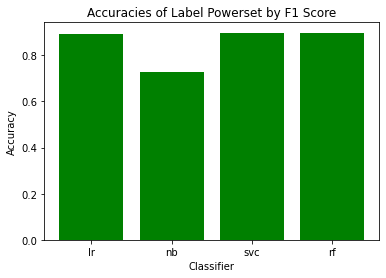

In [28]:
plt.bar(accuracies_lps.keys(), accuracies_lps.values(), color='green')
plt.ylabel('Accuracy')
plt.xlabel('Classifier')
plt.title('Accuracies of Label Powerset by F1 Score')
plt.show()

<b> Summary of Non-OneVsRest Results:</b>

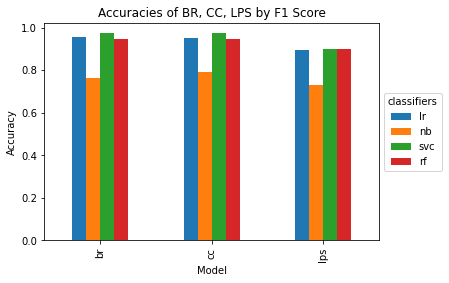

In [29]:
non_onevsrest_results = {'br': accuracies_br, 
                    'cc': accuracies_cc, 
                    'lps': accuracies_lps}
pd.DataFrame(non_onevsrest_results).T.plot(kind='bar', title='Accuracies of BR, CC, LPS by F1 Score')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.legend(title='classifiers', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### Adapted Algorithm (MLkNN)

In [30]:
# Import our original training and testing data
X_train2 = X_train2['no_stop_words']
X_test2 = X_test2['no_stop_words']

# Vectorize using Tfidf
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train2)
vectorizer.fit(X_test2)

X_train2 = vectorizer.transform(X_train2)
X_test2 = vectorizer.transform(X_test2)

In [31]:
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix

classifier_new = MLkNN(k=10)

X_train = lil_matrix(X_train2).toarray()
y_train = lil_matrix(y_train).toarray()
X_test = lil_matrix(X_test2).toarray()

# Train
classifier_new.fit(X_train2, y_train)

# Predict
predictions_new = classifier_new.predict(X_test2)

# Measure accuracy
print("Test accuracy is", f1_score(y_test,predictions_new, average='samples'))
print("\n")

C:\Users\mdjm0\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Test accuracy is 0.6328537015528884




<b> Summary of Results: </b>

Before any model tuning and hyperparamers we see that our most successful model is OneVsRest, though Binary Relevance and Classifer Chains perform very well with certain classifiers.  

OneVsRest performs well with each of the four classifiers we have tested, though Logistic Regression, C-Support Vector Classification, and Random Forest classifiers seem more promising than Multinomial Naive Bayes. 

An initial test of the adapted k-Nearest Neighbours model, MLkNN, was somewhat successful.  We will explore tuning this.

<b> A function to generated predicted labels for OneVsRest</b>

In [32]:
X_train = pd.read_csv('Data\X_train_nlp.csv')
X_test = pd.read_csv('Data\X_test_nlp.csv')
y_train = pd.read_csv('Data\y_train_nlp.csv')
y_test = pd.read_csv('Data\y_test_nlp.csv')

X_train = X_train['no_stop_words']
X_test = X_test['no_stop_words']

In [33]:
"""
This function will take a row number as input.
It will produce the predicted labels for that row using OneVsRest and each of the four classifiers.
It will allow us to compare these predictions against the desired results.
"""

def ovr_predict_labels_all_classifiers(row):
    classifiers = {'LR': LogisticRegression(), 
                   'MNB': MultinomialNB(), 
                   'SVC': LinearSVC(), 
                   'RF': RandomForestClassifier()}
    
    #Retrieve correct labels for the row 
    print("True Labels:", list(y_test.iloc[row].values))
    print("\nPredicted Labels:")
    
    for name, classifier in classifiers.items():
        # Define a OneVsRest pipeline for each classifier
        classifier_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(classifier, n_jobs=1)),
                ])
        pred_labels = []
        # Train the model on each category
        for category in categories:
            classifier_pipeline.fit(X_train, y_train[category])
     
            # Predict the label for the given category
            prediction = classifier_pipeline.predict(X_test)
            pred_labels.append(prediction[row])
        print(name, pred_labels)

In [34]:
ovr_predict_labels_all_classifiers(4)

True Labels: [1, 0, 0, 0, 1]

Predicted Labels:
LR [1, 0, 0, 0, 1]
MNB [1, 0, 0, 0, 0]
SVC [1, 0, 0, 0, 1]
RF [1, 0, 0, 0, 1]


### Fine Tuning the OneVsRest Models

In [35]:
# Logistic Regression
# OneVs Rest with Logistic Regression Classifer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(), n_jobs=1)),
                ])

# Create a dictionary of the accuracies for plotting 
accuracies_ovr_lr = dict()
for category in categories:
        
    # Training logistic regression model on training data
    LogReg_pipeline.fit(X_train, y_train[category])
    
    # Predicting and calculating test accuracy
    prediction = LogReg_pipeline.predict(X_test)
    accuracies_ovr_lr[category] = balanced_accuracy_score(y_test[category], prediction)
    print('Test accuracy for {} labels is {}'.format(category, accuracies_ovr_lr[category]))

Test accuracy for outerwear labels is 0.9454689252538035
Test accuracy for tops labels is 0.9634146341463414
Test accuracy for pants labels is 0.9612384858468366
Test accuracy for dresses labels is 0.9742607999881461
Test accuracy for skirts labels is 0.9842014962034318


In [36]:
# Logistic Regression
# OneVs Rest with Logistic Regression Classifer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', penalty='l1'), n_jobs=1)),
                ])

# Create a dictionary of the accuracies for plotting 
accuracies_ovr_lr = dict()
for category in categories:
        
    # Training logistic regression model on training data
    LogReg_pipeline.fit(X_train, y_train[category])
    
    # Predicting and calculating test accuracy
    prediction = LogReg_pipeline.predict(X_test)
    accuracies_ovr_lr[category] = balanced_accuracy_score(y_test[category], prediction)
    print('Test accuracy for {} labels is {}'.format(category, accuracies_ovr_lr[category]))

Test accuracy for outerwear labels is 0.9513046586441082
Test accuracy for tops labels is 0.9650406504065041
Test accuracy for pants labels is 0.9626728523723078
Test accuracy for dresses labels is 0.984967068463516
Test accuracy for skirts labels is 0.9877472711474089


We have a very slight improvement across all five labels with this tuning.

In [37]:
# RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier

RF_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(RandomForestClassifier(), n_jobs=1)),
                ])
    
accuracies_ovr_rf = dict()

for category in categories:
    
    RF_pipeline.fit(X_train, y_train[category])
    
    prediction = RF_pipeline.predict(X_test)
    accuracies_ovr_rf[category] = balanced_accuracy_score(y_test[category], prediction)
    print('Test accuracy for {} labels is {}'.format(category, accuracies_ovr_rf[category]))

Test accuracy for outerwear labels is 0.9439130309740876
Test accuracy for tops labels is 0.9603658536585367
Test accuracy for pants labels is 0.9386248010937045
Test accuracy for dresses labels is 0.9855079013461553
Test accuracy for skirts labels is 0.9880179804056656


In [38]:
# RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier

RF_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(RandomForestClassifier(criterion = 'entropy', n_estimators = 100), n_jobs=1)),
                ])
    
accuracies_ovr_rf = dict()

for category in categories:
    
    RF_pipeline.fit(X_train, y_train[category])
    
    prediction = RF_pipeline.predict(X_test)
    accuracies_ovr_rf[category] = balanced_accuracy_score(y_test[category], prediction)
    print('Test accuracy for {} labels is {}'.format(category, accuracies_ovr_rf[category]))

Test accuracy for outerwear labels is 0.9452031043932341
Test accuracy for tops labels is 0.9638211382113822
Test accuracy for pants labels is 0.9396221340684462
Test accuracy for dresses labels is 0.983579424642717
Test accuracy for skirts labels is 0.9801143027429413
